In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('SBIN.NS.csv')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
df.iloc[:,1:2]

,Open
0,18.691147
1,18.894005
2,18.327892
3,17.502312
4,17.738192
...,...
6768,599.099976
6769,601.000000
6770,602.099976
6771,598.150024


In [5]:
from tensorflow.keras.models import load_model

2022-12-01 12:36:58.818619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model = load_model('sbi_model.h5')

2022-12-01 12:37:02.022562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6773 entries, 0 to 6772
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6773 non-null   object 
 1   Open       6764 non-null   float64
 2   High       6764 non-null   float64
 3   Low        6764 non-null   float64
 4   Close      6764 non-null   float64
 5   Adj Close  6764 non-null   float64
 6   Volume     6764 non-null   float64
dtypes: float64(6), object(1)
memory usage: 370.5+ KB


In [8]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6768,2022-11-17,599.099976,602.750000,596.150024,599.049988,599.049988,8167131.0
6769,2022-11-18,601.000000,605.750000,597.150024,602.700012,602.700012,12933675.0
6770,2022-11-21,602.099976,602.099976,595.349976,598.099976,598.099976,7412419.0
6771,2022-11-22,598.150024,600.700012,596.150024,599.099976,599.099976,8048595.0
6772,2022-11-23,601.549988,609.599976,601.000000,607.650024,607.650024,12435924.0


<AxesSubplot:xlabel='Date', ylabel='Open'>

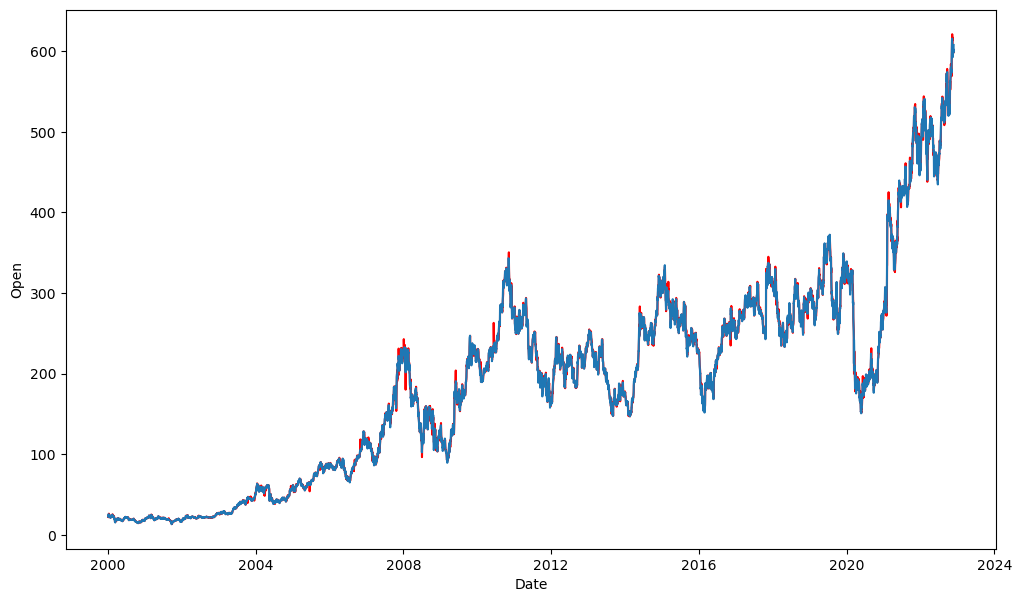

In [9]:
import datetime
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12,7))
sns.lineplot(x='Date', y='Open',
             color='red',
             data=df[df['Date'] > pd.to_datetime(datetime.date(2000,1,1))])
sns.lineplot(x='Date', y='Close', 
             data=df[df['Date'] > pd.to_datetime(datetime.date(2000,1,1))])

## Prediction with predicted value tests

In [10]:
df = df.dropna()

In [11]:
train_ind = int(len(df)*0.8)
df_train = df[:train_ind]
df_test = df[train_ind:]

In [12]:
df_test

,Date,Open,High,Low,Close,Adj Close,Volume
5420,2017-06-05,288.049988,289.750000,286.750000,287.250000,280.248627,7917410.0
5421,2017-06-06,292.000000,292.950012,286.600006,287.299988,280.297394,12346121.0
5422,2017-06-07,288.200012,291.500000,287.200012,290.549988,283.468170,10864355.0
5423,2017-06-08,292.000000,292.000000,287.750000,288.600006,281.565735,8370299.0
5424,2017-06-09,288.299988,289.399994,285.799988,288.549988,281.516907,10804887.0
...,...,...,...,...,...,...,...
6768,2022-11-17,599.099976,602.750000,596.150024,599.049988,599.049988,8167131.0
6769,2022-11-18,601.000000,605.750000,597.150024,602.700012,602.700012,12933675.0
6770,2022-11-21,602.099976,602.099976,595.349976,598.099976,598.099976,7412419.0
6771,2022-11-22,598.150024,600.700012,596.150024,599.099976,599.099976,8048595.0


In [13]:
timestep = 60

In [14]:
r_data = df_test.iloc[:60, 1:2].values

In [15]:
len(r_data)

60

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [17]:
r_data = scaler.fit_transform(r_data)

In [18]:
r_data.shape

(60, 1)

In [19]:
r_data = np.reshape(r_data, (1, timestep, 1))

In [20]:
r_data.shape

(1, 60, 1)

In [22]:
t_data = r_data

In [24]:
p1 = model.predict(r_data)

1/1 [==============================] - 1s 887ms/step


In [25]:
p1 = scaler.inverse_transform(p1)

In [26]:
p1[0].tolist()[0]

279.929443359375

In [27]:
df_test.iloc[61]

Date         2017-09-01 00:00:00
Open                  277.649994
High                  280.399994
Low                   276.600006
Close                 277.850006
Adj Close             271.077759
Volume                 8255209.0
Name: 5481, dtype: object

In [91]:
# data_till_friday should be scaled and in shape (1,60,1)
def weekly_prediction(model, data_till_friday,scaler):
    lst_output=[]
    i=0
    while i<5:
        lst_input = [x[0] for x in data_till_friday[0]]
        p = model.predict(data_till_friday)
        x = lst_input[1:]
        x.append(p[0].tolist()[0])
        p = scaler.inverse_transform(p)
        lst_output.append(p[0].tolist()[0])
        data_till_friday = np.array(x).reshape(1,60,1)
        i+=1
    return lst_output
        

In [92]:
res = weekly_prediction(model, r_data, scaler)

1/1 [==============================] - 0s 23ms/step


In [93]:
res_d = pd.DataFrame(res)
res_d

,0
0,279.929443
1,279.654419
2,279.435516
3,279.310181
4,279.233582


<AxesSubplot:>

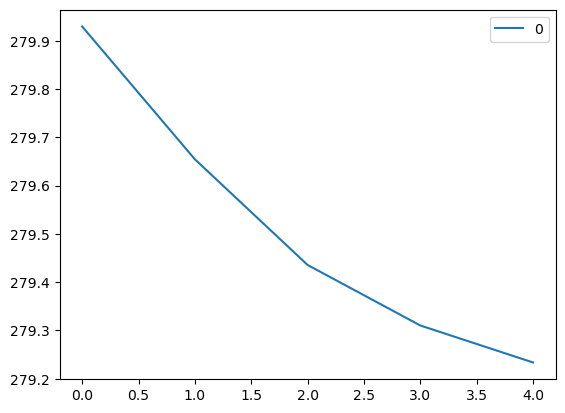

In [94]:
res_d.plot()

In [95]:
res_d

,0
0,279.929443
1,279.654419
2,279.435516
3,279.310181
4,279.233582


<AxesSubplot:>

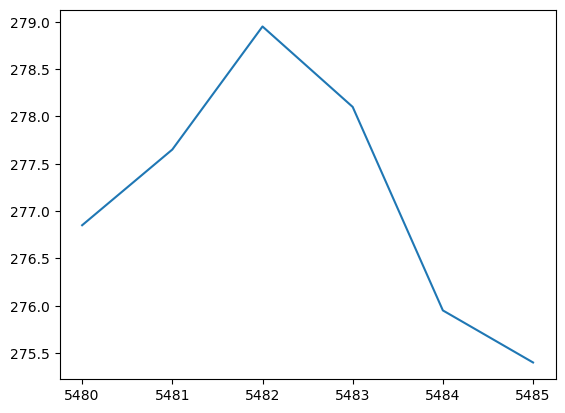

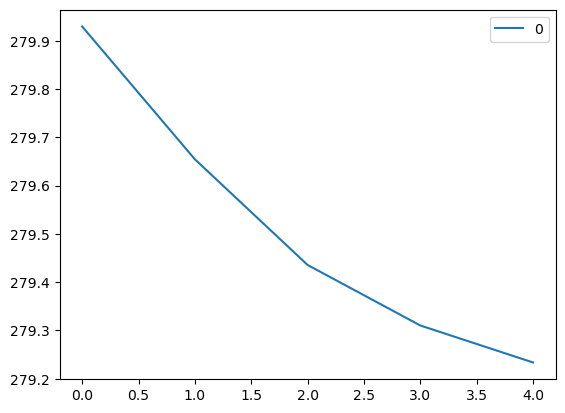

In [97]:
df_test[60:66]['Open'].plot()
res_d.plot()

## Continuous weekly prediction

In [100]:
w_data = df_test.iloc[:,1:2].values

In [103]:
w_data.shape
w_data = scaler.transform(w_data)

In [104]:
w_test = []
for i in range(timestep, len(w_data)):
    w_test.append(w_data[i-timestep:i, 0])
w_test = np.array(w_test)
w_test = np.reshape(w_test, (w_test.shape[0], w_test.shape[1], 1))

In [109]:
w_test.shape

(1293, 60, 1)

In [115]:
w_result =[weekly_prediction(model,x.reshape(1, len(x),1), scaler) for x in w_test]

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


In [134]:
w_result

[[279.929443359375,
  279.6544189453125,
  279.4355163574219,
  279.3101806640625,
  279.23358154296875],
 [279.1650390625,
  278.5006103515625,
  278.170166015625,
  278.0820617675781,
  278.0786437988281],
 [278.2801513671875,
  277.73040771484375,
  277.5359802246094,
  277.5245666503906,
  277.54327392578125],
 [277.8310241699219,
  277.73651123046875,
  277.7711181640625,
  277.7919616699219,
  277.75836181640625],
 [277.77947998046875,
  277.85430908203125,
  277.892578125,
  277.859375,
  277.7737121582031],
 [277.5690612792969,
  277.3446350097656,
  277.193603515625,
  277.10205078125,
  277.0265197753906],
 [277.0337829589844,
  276.5814514160156,
  276.3442077636719,
  276.2557067871094,
  276.2113342285156],
 [276.2964782714844,
  275.7685546875,
  275.5325012207031,
  275.47149658203125,
  275.4517517089844],
 [275.31402587890625,
  274.59417724609375,
  274.2737731933594,
  274.2161560058594,
  274.23699951171875],
 [274.2190856933594,
  273.4785461425781,
  273.183898925

In [118]:
nw = np.array(w_result)

In [135]:
nw.shape

(1293, 5)

In [128]:
final = np.concatenate(nw)

In [132]:
final.shape

(6465,)

In [137]:
len([x[-1] for x in nw])

1293

In [138]:
w_final = [x[-1] for x in nw]

In [139]:
w_final

[279.23358154296875,
 278.0786437988281,
 277.54327392578125,
 277.75836181640625,
 277.7737121582031,
 277.0265197753906,
 276.2113342285156,
 275.4517517089844,
 274.23699951171875,
 273.21417236328125,
 273.452880859375,
 273.3265686035156,
 272.4031677246094,
 272.3010559082031,
 271.4891357421875,
 270.2016906738281,
 269.6773986816406,
 268.7113037109375,
 266.5901794433594,
 264.34063720703125,
 262.99560546875,
 260.1824035644531,
 258.87359619140625,
 258.3383483886719,
 257.14599609375,
 256.6138000488281,
 255.9235076904297,
 256.2704162597656,
 256.6085205078125,
 256.88775634765625,
 255.939208984375,
 254.84017944335938,
 254.5033721923828,
 253.82423400878906,
 252.28775024414062,
 250.6980743408203,
 249.44723510742188,
 248.77259826660156,
 255.2868194580078,
 287.6123046875,
 288.2500915527344,
 286.3503112792969,
 291.30352783203125,
 295.52685546875,
 303.513427734375,
 304.80810546875,
 307.4377136230469,
 310.4141540527344,
 310.4795837402344,
 310.1836853027344,


<AxesSubplot:>

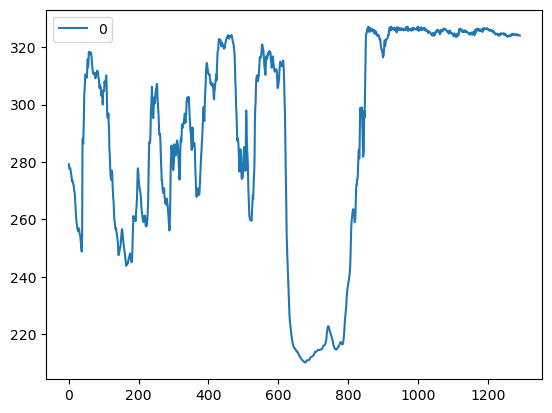

In [140]:
pd.DataFrame(w_final).plot()

<AxesSubplot:ylabel='Open'>

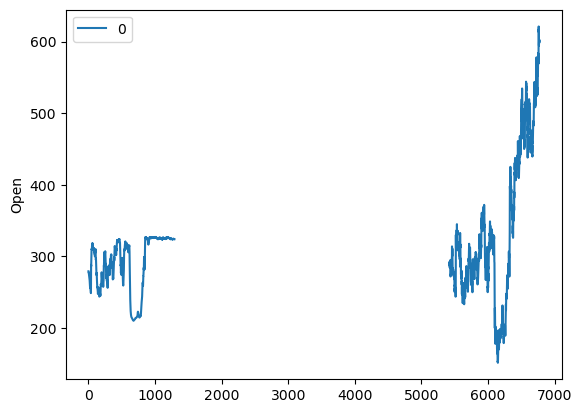

In [149]:
sns.lineplot(data=df_test['Open'])
sns.lineplot(data =pd.DataFrame(w_final))